In [24]:
# importing libraries

# Utilities
import re 
import pickle
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# Models
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flurp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [2]:
# reading in data
dataset = pd.read_csv("../Raw_Data/Raw/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", 
                      header=None, names=["sentiment", "ids", "date", "flag", "user", "text"])

In [3]:
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# We only want the sentiment and text columns
dataset = dataset[["sentiment", "text"]]

In [5]:
# original dataset has negative sentiment = 0 and positive sentiment = 4, 
# we are changing positive sentiment to 1 for ease of understanding
dataset["sentiment"] = dataset["sentiment"].replace(4,1)

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

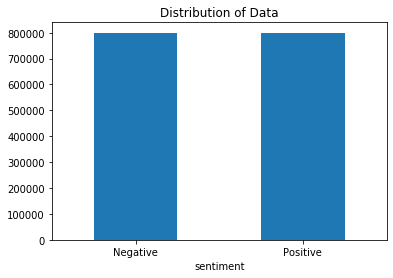

In [6]:
# Plotting total number of positive and negative sentiment tweets
ax = dataset.groupby("sentiment").count().plot(kind="bar", title = "Distribution of Data", legend = False)
ax.set_xticklabels(["Negative", "Positive"], rotation=0)

In [7]:
text, sentiment = list(dataset["text"]), list(dataset["sentiment"])

In [61]:
text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## Preprocessing

In [11]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [12]:
## Defining set containing all stopwords in english from sklearn library
stopwordlist = ENGLISH_STOP_WORDS

In [21]:
def preprocess(data):
    processed_text = []
    
    # Defining dictionary containing all emojis with their meanings.
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
    
    ## Defining set containing all stopwords in english from sklearn library
    stopwordlist = ENGLISH_STOP_WORDS
    
    # Creating Lemmatizer
    lemm = WordNetLemmatizer()
    
    # Defining regex patterns
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
    user_pattern = r"@[^\s]+"
    non_alphabet = r"[^a-zA-Z0-9]"
    three_chars = r"(.)\1\1+"
    two_chars = r"\1\1"
    
    for tweet in data:
        # Lowercase all words
        tweet = tweet.lower()
        # Replace all URL's with "URL"
        tweet = re.sub(url_pattern, "URL", tweet)
        # Replace username @ handle with "USER"
        tweet = re.sub(user_pattern, "USER", tweet)
        # Replace emojis with meaning behind emoji
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace all non alphabetical chars 
        # Replace 3 or more consecutive letters by 2 letters
        
        # Initiate processed tweet string
        lemm_words = ''
        # Lemmatize tweet
        for word in tweet.split():
            #Check if word is a stop word
            if word not in stopwordlist:
                # Check if word is longer than 1 char
                if len(word) > 1:
                    word = lemm.lemmatize(word)
                    lemm_words += (word+" ")
        
        processed_text.append(lemm_words)
    return processed_text

In [25]:
import time
t = time.time()
processed_text = preprocess(text)

print(f"time to process: {time.time() - t}")

time to process: 87.32022523880005


### Wordclouds for negative and positive tweets (which words occur the most)

In [44]:
from wordcloud import wordcloud

In [45]:
neg_data = processed_text[:800000]
wordcloud = wordcloud.WordCloud(max_words = 1000,collocations = False)\
                                .generate(" ".join(neg_data))

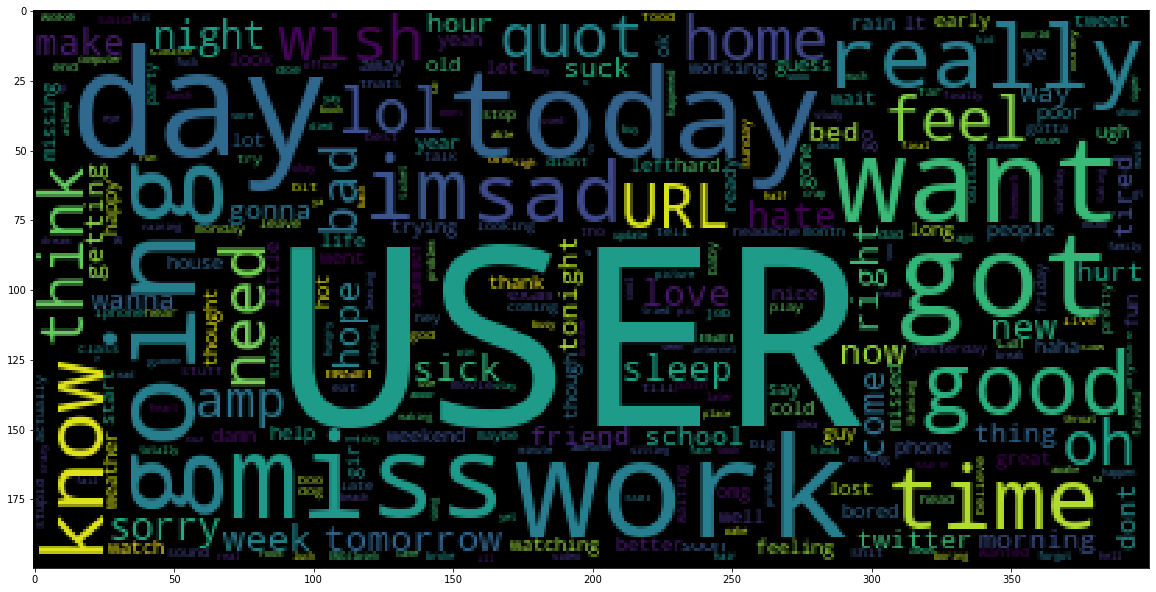

In [46]:
plt.figure(figsize=(20,20))
plt.imshow(wordcloud)

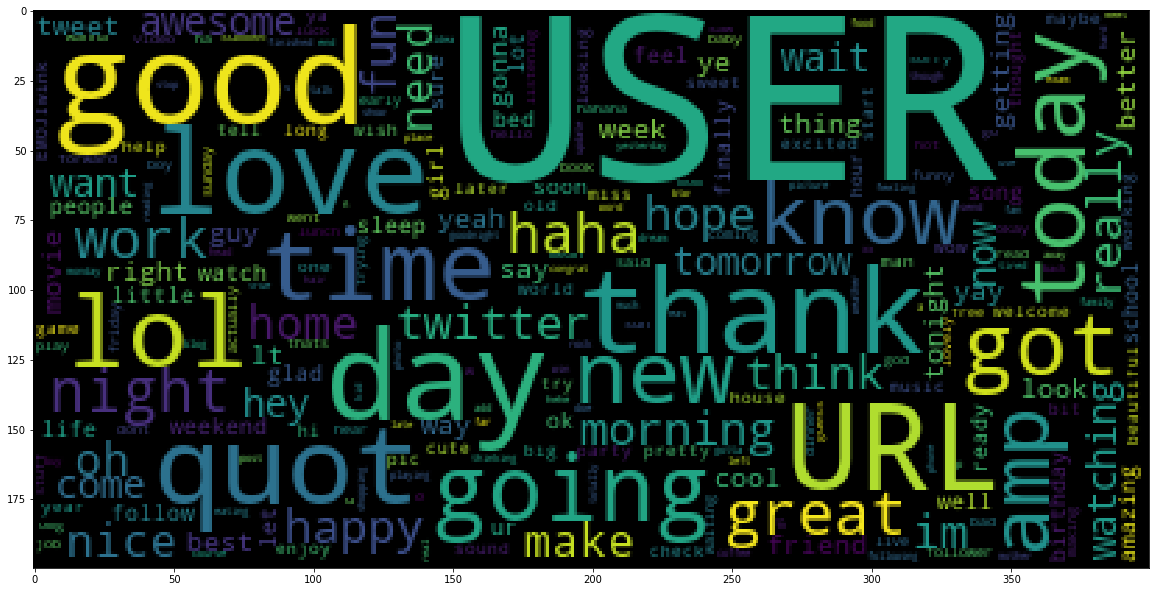

In [41]:
pos_data = processed_text[800000:]
wordcloud = wordcloud.WordCloud(max_words = 1000,collocations = False)\
                                .generate(" ".join(pos_data))
plt.figure(figsize=(20,20))
plt.imshow(wordcloud)

## Training the model

In [47]:
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment, random_state = 0)

In [48]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=500000, min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [50]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [52]:
classifier = LogisticRegression(max_iter= 1000, C = 2)
classifier.fit(X_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
classifier.score(X_train, y_train)

0.85399

In [54]:
classifier.score(X_test, y_test)

0.796125

## Save Models

In [85]:
file = open("../Models/LR_model.pickle", "wb")
pickle.dump(classifier, file)

In [86]:
file = open("../Models/vectorizer.pickle", "wb")
pickle.dump(vectorizer, file)